In [1]:
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from pprint import pprint
import keras
import sklearn
import tensorflow as tf
tf.__version__

'2.15.1'

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Import the data

In [1]:
def load_dico(path,key_int=False,print_me=False):
    with open(path) as f:
        dico_str = json.loads(json.load(f))

    if key_int:
        conv_key=lambda k:int(k)
    else:
        conv_key=lambda k:k

    dico={conv_key(k):v for k,v in dico_str.items()}

    if print_me:
        print(dico)

    return dico

In [4]:
class classCLASS:

    def __init__(self,id,name,behaviors,sampling_weight=1,loss_weight=1):
        self.id=id
        self.name=name
        self.behaviors=behaviors
        self.sampling_weight=sampling_weight
        self.loss_weight=loss_weight

In [7]:
""" a dictionary to store all the information """
memo=pd.Series()

In [5]:
#Path to the folder containing the Hawksbill dataset downloaded from Zenodo
Folder_data="~/Hawksbill"


In [9]:
#Split the data into training/validation/testing dataset based on the individuals
NAMES_TRAIN=memo["NAMES_TRAIN"]=[
    'CC-09-80_08-03-2023_1',
    'CC-09-80_08-03-2023_2',
    'CC-09-72_02-11-2022_1',
    'CC-09-80_16-05-2023_1',
    'CC-09-80_16-05-2023_2']

NAMES_VAL=memo["NAMES_VAL"]=[
    'CC-09-72_01-02-2023_1',
    'CC-09-72_01-02-2023_2',
    ]


NAMES_TEST=memo["NAMES_TEST"]=[
    'CC-09-80_28-03-2023_1',
    'CC-09-80_28-03-2023_2',

    'CC-09-80_01-02-2023_1']

NAMES_ALL=NAMES_TRAIN+NAMES_VAL+NAMES_TEST

In [10]:
dico_info_A=load_dico(Folder_data+"/dico_info.json",print_me=True);

{'Freq': 20, 'col_names': ['Accelerometer X [m/s²]', 'Accelerometer Y [m/s²]', 'Accelerometer Z [m/s²]', 'Gyroscope X [mrad/s]', 'Gyroscope Y [mrad/s]', 'Gyroscope Z [mrad/s]', 'Magnetometer X [µT]', 'Magnetometer Y [µT]', 'Magnetometer Z [µT]', 'Depth [m]', 'Light intensity 1 [raw]', 'Temperature (depth) [°C]', 'Pressure_corr', 'Pressure_diff', 'beh']}


In [12]:
# Parameters

Other=classCLASS(0,"Other",None,1,1)
Breathing=classCLASS(1,"Breathing",[1,2,46,47],1,1)
Feeding=classCLASS(2,"Feeding",[3,4,5,6,7,8,12,13,14,15,20,21,22,23,24,26,29,30,33],1,2)
Gliding=classCLASS(3,"Gliding",[18,19],1,1)
Resting=classCLASS(4,"Resting",[35,36,37,38],1,1)
Scratching=classCLASS(5,"Scratching",[40,41,42],1,2)
Swimming=classCLASS(6,"Swimming",[0,9,10,11,17,34,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,66,67,69],1,2)
CLASSES=[Other,Breathing,Feeding,Gliding,Resting,Scratching,Swimming]

DESCRIPTORS_SELEC=[0,1,2,3,4,5,13] #the variables selected to train the Vnet
FREQ=20
WINDOW_DURA=40 #size of the window in seconds
WINDOW_SIZE=int(WINDOW_DURA*FREQ) #size of the window and therefore input
BEH_COL=14


#Parameters of the Vnet
LR_initial=0.0001
BATCH_SIZE=32
MODEL_DEPTH=32
MODEL_HEAD="softmax"
DROPOUT=0.5

In [13]:
#Check the columns we selected

DESC_NAMES=dico_info_A['col_names']
DESC_NAMES_SELEC=[]
for i,name in enumerate(DESC_NAMES):
    if i in DESCRIPTORS_SELEC:
        prefix=""
        DESC_NAMES_SELEC.append(name)
    else:
        prefix="-----suppressed----->"
    print(prefix,i,name)


 0 Accelerometer X [m/s²]
 1 Accelerometer Y [m/s²]
 2 Accelerometer Z [m/s²]
 3 Gyroscope X [mrad/s]
 4 Gyroscope Y [mrad/s]
 5 Gyroscope Z [mrad/s]
-----suppressed-----> 6 Magnetometer X [µT]
-----suppressed-----> 7 Magnetometer Y [µT]
-----suppressed-----> 8 Magnetometer Z [µT]
-----suppressed-----> 9 Depth [m]
-----suppressed-----> 10 Light intensity 1 [raw]
-----suppressed-----> 11 Temperature (depth) [°C]
-----suppressed-----> 12 Pressure_corr
 13 Pressure_diff
-----suppressed-----> 14 beh


In [14]:
#save everyhting in dictionary
memo["MODEL_HEAD"]=MODEL_HEAD
memo["MODEL_DEPTH"]=MODEL_DEPTH
memo["BATCH_SIZE"]=BATCH_SIZE
memo["LR_initial"]=LR_initial

memo["WINDOW_DURA"]=WINDOW_DURA
memo["FREQ"]=FREQ
for CLASS in CLASSES:
    memo["CLASSES_"+CLASS.name]=CLASS.__dict__
memo["DROPOUT"]=DROPOUT
memo["DESCRIPTORS_SELEC"]=DESCRIPTORS_SELEC

## Load matrices



In [15]:
Matrices={}
Labels={}

for name in NAMES_ALL:
        print(name)
        full_name=Folder_data+"/"+name+".npy"
        if not os.path.exists(full_name):
            assert 1==0,"the file:"+full_name+" doesn't exist"
        else:
            full_mat=np.load(full_name)
            pre_label= full_mat[:,BEH_COL]

            label=np.zeros_like(pre_label)
            for CLASS in CLASSES:
                if CLASS!=Other:
                    for beh in CLASS.behaviors:
                        label[pre_label==beh]=CLASS.id

            mat=full_mat[:,DESCRIPTORS_SELEC]
            print("loading the matrice:"+name)
            print("shape:",mat.shape)
            print("Time in seconds:",len(mat)/FREQ)
            print("Time in hours:",round(len(mat)/FREQ/60/60,2))
            print("              ")
            Matrices[name]=mat
            Labels[name]=label



CC-09-80_08-03-2023_1
loading the matrice:CC-09-80_08-03-2023_1
shape: (531000, 7)
Time in seconds: 26550.0
Time in hours: 7.38
              
CC-09-80_08-03-2023_2
loading the matrice:CC-09-80_08-03-2023_2
shape: (420299, 7)
Time in seconds: 21014.95
Time in hours: 5.84
              
CC-09-72_02-11-2022_1
loading the matrice:CC-09-72_02-11-2022_1
shape: (685601, 7)
Time in seconds: 34280.05
Time in hours: 9.52
              
CC-09-80_16-05-2023_1
loading the matrice:CC-09-80_16-05-2023_1
shape: (480267, 7)
Time in seconds: 24013.35
Time in hours: 6.67
              
CC-09-80_16-05-2023_2
loading the matrice:CC-09-80_16-05-2023_2
shape: (232536, 7)
Time in seconds: 11626.8
Time in hours: 3.23
              
CC-09-72_01-02-2023_1
loading the matrice:CC-09-72_01-02-2023_1
shape: (615327, 7)
Time in seconds: 30766.35
Time in hours: 8.55
              
CC-09-72_01-02-2023_2
loading the matrice:CC-09-72_01-02-2023_2
shape: (663280, 7)
Time in seconds: 33164.0
Time in hours: 9.21
          

### Normalize

In [16]:
nb_col=Matrices[NAMES_ALL[0]].shape[1]
for matrix in Matrices.values():
        for j in range(nb_col):
            matrix[:,j]-=matrix[:,j].mean()
            matrix[:,j]/=matrix[:,j].std()

# Create Folder with the date of today to save the predictions

In [17]:
import datetime
now = datetime.datetime.now()
today=now.strftime("%Y_%m_%d")
today

'2024_06_01'

In [ ]:
#Path of the folder where to save the model and predictions
Folder_out="~/Out_model/Case2/model="+today

import shutil
if os.path.exists(Folder_out):
    #shutil.rmtree(DIR_OUT)
    print("the directory already created:",Folder_out)
else:
    print("we create the directory:",Folder_out)
    os.makedirs(Folder_out)


# Data Generator

In [37]:
def density_for_one_promotion(turtle_name, CLASS):

    label=Labels[turtle_name]

    N = len(label)
    dens = np.zeros_like(label)

    dens[label==CLASS.id] = 1

    sum_dens=np.sum(dens)
    if  sum_dens<1e-6:
        print("the class to promote:"+CLASS.name +" is not present in:"+turtle_name)
        dens[:]=1
        sum_dens=len(dens)


    dens/=sum_dens

    # creating a mask.
    kernel = np.ones(int(1.5*WINDOW_SIZE)) 
    kernel/=np.sum(kernel)
    #gauss = np.exp(-t**2)
    #gauss /= np.sum(gauss)

    # convolving label with a mask
    dens_conv = np.convolve(dens, kernel, mode='same') 

    dens_conv[-WINDOW_SIZE//2-2:]=0
    dens_conv[:WINDOW_SIZE//2+2]=0

    cdf=np.cumsum(dens_conv)
    cdf/=cdf[-1]

    def rand_gene():
        while True:
                yield np.argmax(cdf>np.random.random())-WINDOW_SIZE//2

    return dens,dens_conv,cdf,rand_gene()

In [38]:
class InterestingTurtles:

    def __init__(self,turtle_names,CLASS):
        self.turtle_names=turtle_names
        self.occurences=np.zeros(len(turtle_names))
        self.CLASS=CLASS

        for i,name in enumerate(turtle_names):
            self.occurences[i]+=np.sum(Labels[name]==CLASS.id)

        self.proba=self.occurences/np.sum(self.occurences)

    def give_me_one_turtle(self):
        return np.random.choice(a=self.turtle_names,p=self.proba)

### Global generator
(See Jeantet et al. 2021 for details)\
The global generator draws a data window among the specified individuals (turtle_names), favoring a window that contains behaviors with a higher class.sampling_weight index. 10% of the windows are randomly selected without taking into account the sampling_weight index. 
In detail:  

* We draw a behavior (theClass) based on CLASS.sampling_weight
* We select a turtle (theTurtle) based on InterestingTurtles function which going to give a individual who express this behavior (higher probability if the individual express this behavior more than the other one)
* We draw a time window using the density_for_one_promotion generator associated with the turtle and the behavior.

In [39]:
class Global_generator:

    def __init__(self,turtle_names):

        self.turtle_names=turtle_names

        self.interesting_turtles_by_class={}

        self.proba_of_classes=np.zeros(len(CLASSES))

        for CLASS in CLASSES:
            self.interesting_turtles_by_class[CLASS.name]=InterestingTurtles(turtle_names,CLASS)
            self.proba_of_classes[CLASS.id]=CLASS.sampling_weight

        self.proba_of_classes/=np.sum(self.proba_of_classes)


        print([ (CLASS.name,self.proba_of_classes[CLASS.id]) for CLASS in CLASSES])


        self.class_2_index_gene={}

        for CLASS in CLASSES:

            random_index_generators={}
            for name in turtle_names:
                _,_,_,gene=density_for_one_promotion(name,CLASS)
                random_index_generators[name]=gene

            self.class_2_index_gene[CLASS.name]=random_index_generators



    def give_me_turtle_and_timeIndex(self):

        if np.random.rand()<0.1:
            theTurtle=np.random.choice(self.turtle_names)
            deb=0
            fin=len(Labels[theTurtle])-WINDOW_SIZE
            t=np.random.randint(deb,fin)
            return theTurtle,t

        theClass=np.random.choice(CLASSES,p=self.proba_of_classes)
        theTurtle=self.interesting_turtles_by_class[theClass.name].give_me_one_turtle()


        theGenerators=self.class_2_index_gene[theClass.name]
        theGenerator=theGenerators[theTurtle]
        return theTurtle,next(theGenerator)

In [40]:
def oneEpoch_generator_window(turtle_names, size=100):


    generator=Global_generator(turtle_names)

    while True:

        X = np.empty([size,WINDOW_SIZE,len(DESCRIPTORS_SELEC)])
        Y = np.empty([size,WINDOW_SIZE],dtype=int)

        for i in range(size):
            turtle_name,t=generator.give_me_turtle_and_timeIndex()
            matrix=Matrices[turtle_name]
            label=Labels[turtle_name]
            X[i,:,:]=matrix[t:t+WINDOW_SIZE ,:]
            Y[i,:]=label[t:t+WINDOW_SIZE]

        yield X, keras.utils.to_categorical(Y,len(CLASSES))


##### Histogram of the behavior distribution with global generator (for 2000 windows)

In [41]:
global_generator=Global_generator(NAMES_ALL)

[('Other', 0.11764705882352941), ('Breathing', 0.11764705882352941), ('Feeding', 0.11764705882352941), ('Gliding', 0.23529411764705882), ('Resting', 0.11764705882352941), ('Scratching', 0.23529411764705882), ('Swimming', 0.058823529411764705)]
the class to promote:Other is not present in:CC-09-80_08-03-2023_1
the class to promote:Other is not present in:CC-09-72_01-02-2023_1
the class to promote:Resting is not present in:CC-09-80_08-03-2023_2
the class to promote:Resting is not present in:CC-09-80_16-05-2023_2
the class to promote:Resting is not present in:CC-09-72_01-02-2023_2
the class to promote:Resting is not present in:CC-09-80_28-03-2023_2
the class to promote:Scratching is not present in:CC-09-80_16-05-2023_2
the class to promote:Scratching is not present in:CC-09-72_01-02-2023_2


In [42]:
res=[]
for i in range(2000):
    theTurtle,t=global_generator.give_me_turtle_and_timeIndex()
    window=Labels[theTurtle][t:t+WINDOW_SIZE]
    res.extend(window)

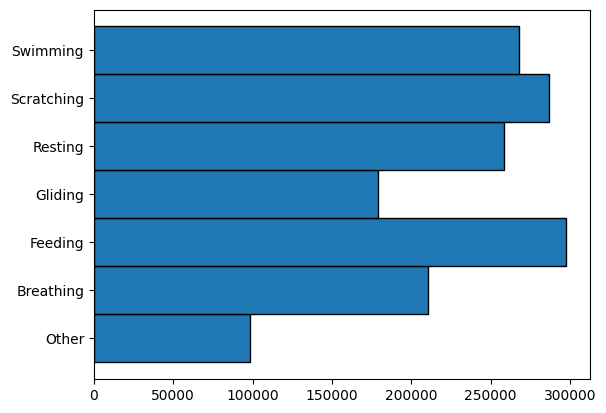

In [43]:
bins=np.arange(len(CLASSES)+1)-0.5
plt.hist(res,bins,edgecolor="k",orientation='horizontal');
xtics=range(len(CLASSES))
xtics_label=[CLASS.name for CLASS in CLASSES]
plt.yticks(xtics,xtics_label);


# V-net Model

In [44]:
#%tensorflow_version 2.x
import keras
import tensorflow as tf
from keras.layers import Conv1D,UpSampling1D,Add,SpatialDropout1D, BatchNormalization,Concatenate
import keras.layers as layers
from tensorflow.keras.utils import to_categorical

In [45]:
class Vnet_4levels:

    def __init__(self):
        self.depth=MODEL_DEPTH
        self.dropout_rate=DROPOUT
        self.batch_norm=True
        self.padding="same"
        self.kernel_size=5


    def doubleConv(self, Y, depth,NAME=False):
        Y = Conv1D(depth, self.kernel_size, activation="relu", padding='same')(Y)
        if NAME==True:
            Y = Conv1D(depth, self.kernel_size, activation="relu", padding='same',use_bias=False,name='Last_conv')(Y)
        else:
            Y = Conv1D(depth, self.kernel_size, activation="relu", padding='same',use_bias=False)(Y)
        Y = BatchNormalization()(Y)
        Y = SpatialDropout1D(self.dropout_rate)(Y)
        return Y

    def makeUp(self,Y,depth):
        Y = UpSampling1D()(Y)
        return Conv1D(depth,2,activation="relu",padding = "same")(Y)



    def __call__(self,inputs):
        #PATCH_DIM
        conv_1 = self.doubleConv(inputs,self.depth)

        #PATCH_DIM/2
        down_1 = Conv1D(self.depth*2,2, strides=2, padding = "same", activation="relu")(conv_1)
        conv_2 = self.doubleConv(down_1,self.depth*2)

        #PATCH_DIM/4
        Y=Add()([down_1,conv_2])
        down_2 = Conv1D(self.depth*4, 2, strides=2, padding = "same", activation="relu")(Y)
        conv_3 = self.doubleConv(down_2,self.depth*4)

        #PATCH_DIM/8
        Y=Add()([down_2,conv_3])
        down_3 = Conv1D(self.depth*8, 2, strides=2, padding = "same", activation="relu")(Y)
        conv_4 = self.doubleConv(down_3,self.depth*8)

        #PATCH_DIM/4
        up_1=self.makeUp(conv_4,self.depth*4)
        Y = Add()([conv_3, up_1])
        pre_conv_5= self.doubleConv(Y,self.depth*4)
        conv_5=Add()([pre_conv_5,up_1])

        #PATCH_DIM/2
        up_2=self.makeUp(conv_5,self.depth*2)
        Y = Add()([conv_2, up_2])
        pre_conv_6= self.doubleConv(Y,self.depth*2)
        conv_6=Add()([pre_conv_6,up_2])

        #PATCH_DIM
        up_3=self.makeUp(conv_6,self.depth)
        Y = Add()([conv_1, up_3])
        pre_conv_7= self.doubleConv(Y,self.depth,NAME=True)
        conv_7=Add()([pre_conv_7,up_3])

        return conv_7

### Head of the model

In [46]:
def head_classif_multiclass(Y,nb_outputs):

    return Conv1D(nb_outputs, 1,activation=MODEL_HEAD)(Y)


def make_model(window_width,nb_inputs,nb_outputs):

    inputs= keras.Input(shape=(window_width,nb_inputs))

    Y=Vnet_4levels()(inputs)

    outputs=head_classif_multiclass(Y,nb_outputs)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

### Dice and Loss function

In [47]:
def dice_coef_perCat(y_true, y_pred,smooth=1e-8):
    intersection = tf.reduce_sum(y_true * y_pred,axis=[0])
    dice=(2. * intersection + smooth) / (tf.reduce_sum(y_true,axis=[0]) + tf.reduce_sum(y_pred,axis=[0]) + smooth)
    "at the end, we average the categories"
    return dice

In [48]:
ponde=np.array([CLASS.loss_weight for CLASS in CLASSES],dtype=np.float32)
print(ponde)
ponde/=np.sum(ponde)
ponde

[1. 1. 2. 1. 1. 2. 2.]


array([0.1, 0.1, 0.2, 0.1, 0.1, 0.2, 0.2], dtype=float32)

In [49]:
def dice_loss(y_true, y_pred):
    smooth=1e-8

    "we average the dice by category"
    return 1-tf.reduce_mean(dice_coef_perCat(y_true, y_pred,smooth)*ponde)

# Training

In [50]:
import time

class Trainer():

    def __init__(self,model, folder_out):
        self.folder_out=folder_out
        self.model_name=self.folder_out+"/model.json"
        self.weights_name=self.folder_out+"/model.h5"
        self.monitor="val_loss"

        # model
        self.model = model

        # training info
        self.history = None
        self.Nb_epochs = 10
        self.best_epoch = 0
        self.durations = []
        self.total_duration = 0
        self.loss_history = []
        self.val_loss_history = []
        self.acc_history = []
        self.val_acc_history = []
        #self.nb_models = 8

        # evaluation info
        self.score = None
        self.y_true = None
        self.y_pred = None


        self.best_epoch = 0
        self.best_value = 1e10
        self.best_epochs=[]
        self.best_values=[]

        self.epoch_count=-1



    def train(self, nb_additional_epochs, batch_size,train_gene, val_gene, learning_rate=None ,patience=1e10):

        if learning_rate is not None:
          tf.set_value(self.model.optimizer.lr, learning_rate)

        # early stopping initialization
        counter = 0

        # training epoch
        try:
            for k in range(nb_additional_epochs):

                self.epoch_count+=1


                if counter >= patience:
                    print("The model is not improving any more. We stop the training process..")
                    break


                starting_time = time.time()

                # data generation
                print("new data generation")
                X_ep, Y_ep = next(train_gene)
                X_val_ep, Y_val_ep = next(val_gene)

                self.history = self.model.fit(
                    X_ep,
                    Y_ep,
                    batch_size=batch_size,
                    initial_epoch=self.epoch_count,
                    epochs=self.epoch_count+1,
                    validation_data=(X_val_ep,Y_val_ep)
                )


                # saving training epoch history
                duration=time.time()-starting_time
                self.durations.append(duration)
                self.total_duration+=duration

                self.loss_history.append(self.history.history["loss"][0])
                self.val_loss_history.append(self.history.history["val_loss"][0])
                self.acc_history.append(self.history.history["accuracy"][0])
                self.val_acc_history.append(self.history.history["val_accuracy"][0])

                current_value = self.history.history[self.monitor][0]


                if current_value < self.best_value:
                    print(self.monitor +  " improved from {:.5f} to {:.5f}".format(self.best_value, current_value))
                    self.best_value = current_value
                    self.best_epoch = self.epoch_count
                    self._save_model()
                    print("Model is saved on epoch {:d}.".format(self.best_epoch))
                    counter = 0
                    self.best_epochs.append(self.best_epoch)
                    self.best_values.append(self.best_value)

                else:
                    print(self.monitor + " did not improve.")
                    counter += 1


        except KeyboardInterrupt:
            print("\n Interuption volontaire")



    def _save_model(self):

        # serialize model to JSON
        model_json = self.model.to_json()
        with open(self.model_name, "w") as json_file:
              json_file.write(model_json)

        # serialize weights to HDF5
        self.model.save_weights(self.weights_name)



    def plot_training(self):

        print(self.monitor,":",self.best_epoch,self.best_value)
        print(self.best_epochs,self.best_values)



        fig,ax = plt.subplots(2,1 , figsize=(16, 10), sharex=True)

        # loss
        a=np.arange(len(self.loss_history))
        ax[0].plot(a,self.loss_history,label="loss")
        ax[0].plot(a,self.val_loss_history,label="val_loss")
        ax[0].legend()
        ax[0].set_title("Loss per epoch", color='coral', fontsize=16)

        if self.monitor == "val_loss":
            ax[0].plot(self.best_epochs,self.best_values,'o',label="best_loss")


        # accuracy
        ax[1].plot(a,self.acc_history,label="accuracy")
        ax[1].plot(a,self.val_acc_history,label="val_accuracy")
        ax[1].legend()
        ax[1].set_title("Accuracy per epoch", color='coral', fontsize=16)
        if self.monitor == "val_accuracy":
            ax[1].plot(self.best_epochs,self.best_values,'o',label="best_acc")

        ax[1].set_xlabel("epoch")

        fig.savefig(self.folder_out+"/loss_acc_per_epoch.png")

In [51]:
memo["nb_train_per_epoch"]=6000
train_gen=oneEpoch_generator_window(NAMES_TRAIN,size = memo["nb_train_per_epoch"])

X,Y=next(train_gen)
X.shape,Y.shape

[('Other', 0.11764705882352941), ('Breathing', 0.11764705882352941), ('Feeding', 0.11764705882352941), ('Gliding', 0.23529411764705882), ('Resting', 0.11764705882352941), ('Scratching', 0.23529411764705882), ('Swimming', 0.058823529411764705)]
the class to promote:Other is not present in:CC-09-80_08-03-2023_1
the class to promote:Resting is not present in:CC-09-80_08-03-2023_2
the class to promote:Resting is not present in:CC-09-80_16-05-2023_2
the class to promote:Scratching is not present in:CC-09-80_16-05-2023_2


((6000, 800, 7), (6000, 800, 7))

In [52]:
memo["nb_val_per_epoch"]=3000
valid_gen=oneEpoch_generator_window(NAMES_VAL,size = memo["nb_val_per_epoch"])

X_val,Y_val=next(valid_gen)
X_val.shape,Y_val.shape

[('Other', 0.11764705882352941), ('Breathing', 0.11764705882352941), ('Feeding', 0.11764705882352941), ('Gliding', 0.23529411764705882), ('Resting', 0.11764705882352941), ('Scratching', 0.23529411764705882), ('Swimming', 0.058823529411764705)]
the class to promote:Other is not present in:CC-09-72_01-02-2023_1
the class to promote:Resting is not present in:CC-09-72_01-02-2023_2
the class to promote:Scratching is not present in:CC-09-72_01-02-2023_2


((3000, 800, 7), (3000, 800, 7))

In [58]:
NB_OUTPUT=len(CLASSES)
NB_INPUT=len(DESCRIPTORS_SELEC)

####V-net 4 levels
model=make_model(nb_inputs=NB_INPUT,nb_outputs=NB_OUTPUT,window_width=WINDOW_SIZE)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR_initial),loss=dice_loss,metrics=["accuracy"])


memo["function_loss"]="dice_loss"

trainer=Trainer(model, Folder_out)

In [59]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 800, 7)]             0         []                            
                                                                                                  
 conv1d_80 (Conv1D)          (None, 800, 32)              1152      ['input_5[0][0]']             
                                                                                                  
 conv1d_81 (Conv1D)          (None, 800, 32)              5120      ['conv1d_80[0][0]']           
                                                                                                  
 batch_normalization_28 (Ba  (None, 800, 32)              128       ['conv1d_81[0][0]']           
 tchNormalization)                                                                          

In [60]:
trainer.train(20 ,BATCH_SIZE,train_gen,valid_gen)

new data generation



188/188 [==============================] - 30s 127ms/step - loss: 0.9655 - accuracy: 0.3106 - val_loss: 0.9753 - val_accuracy: 0.2592
val_loss improved from 10000000000.00000 to 0.97525
Model is saved on epoch 0.
new data generation
Epoch 2/2
188/188 [==============================] - 22s 119ms/step - loss: 0.9456 - accuracy: 0.4701 - val_loss: 0.9637 - val_accuracy: 0.3864
val_loss improved from 0.97525 to 0.96374
Model is saved on epoch 1.
new data generation
Epoch 3/3
188/188 [==============================] - 24s 126ms/step - loss: 0.9339 - accuracy: 0.5487 - val_loss: 0.9530 - val_accuracy: 0.4516
val_loss improved from 0.96374 to 0.95302
Model is saved on epoch 2.
new data generation
Epoch 4/4
188/188 [==============================] - 24s 125ms/step - loss: 0.9256 - accuracy: 0.6121 - val_loss: 0.9460 - val_accuracy: 0.4958
val_loss improved from 0.95302 to 0.94604
Model is saved on epoch 3.
new data generation
Epoch 5/5
188/188 [==============================] - 25s 131ms/step 

val_loss : 15 0.9135558009147644
[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 14, 15] [0.9752522110939026, 0.9637424945831299, 0.9530152082443237, 0.9460408687591553, 0.945181131362915, 0.9312312006950378, 0.9250207543373108, 0.9234472513198853, 0.9216845035552979, 0.9190977215766907, 0.915413498878479, 0.9135558009147644]


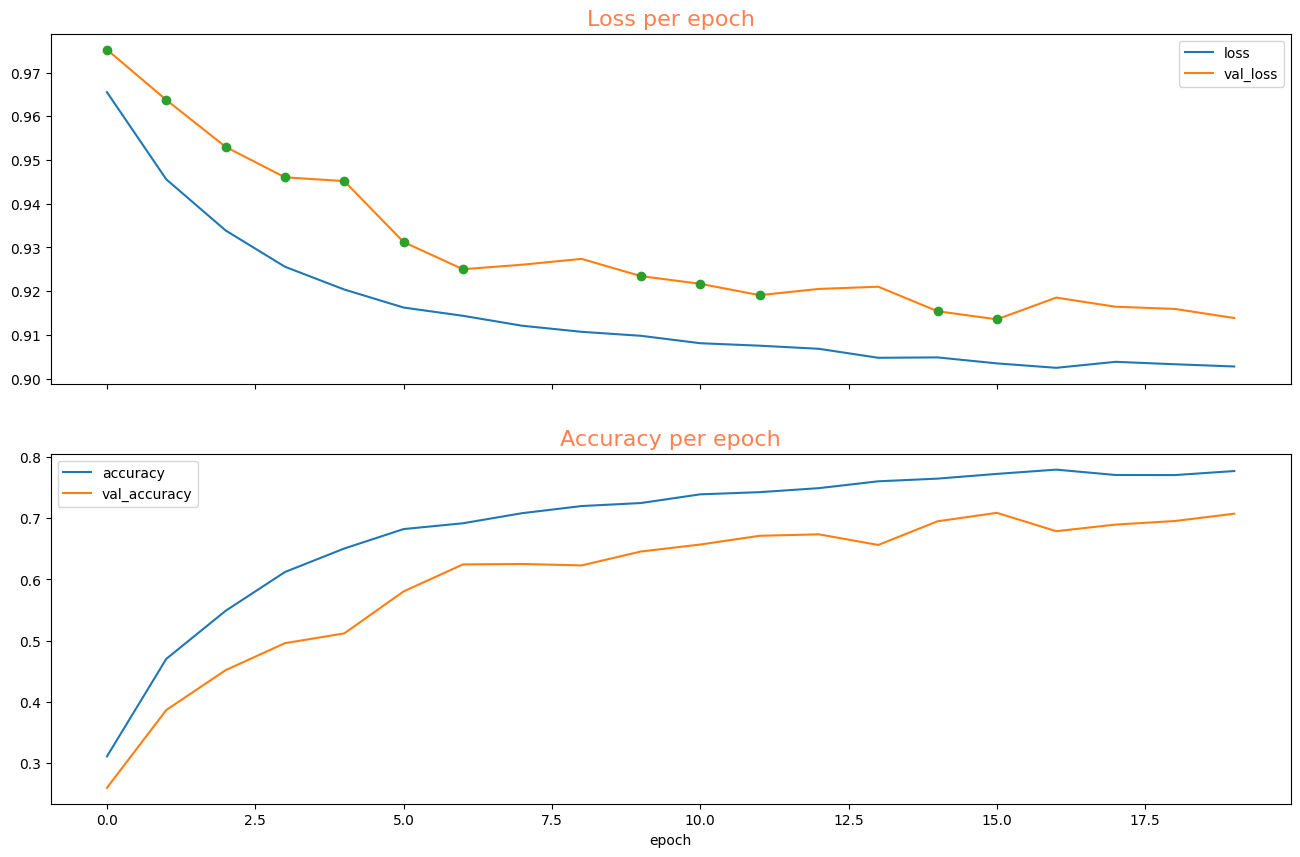

In [61]:
trainer.plot_training()

In [67]:
print("Training took {:.2f} seconds".format(trainer.total_duration))
print("Which is {:.2f} minutes".format(trainer.total_duration/60))

Training took 566.29 seconds
Which is 9.44 minutes


In [ ]:
print(trainer.__dict__)
memo["trainer"]=trainer.__dict__
memo["trainer.epoch_count"]=trainer.epoch_count
memo["trainer.best_epoch"]=trainer.best_epoch
memo["trainer.best_value"]=trainer.best_value
memo["trainer.total_duration"]=trainer.total_duration

In [69]:
#save the memo and the parameters of the model
memo.to_csv(Folder_out+"/memo.csv")

# Testing


In [ ]:
Folder_out

In [71]:
def load_model(model_name=Folder_out+"/model.json", weights_name=Folder_out+"/model.h5"):

    # load json and create model
    json_file = open(model_name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights_name)
    return loaded_model


In [72]:
#load the last model saved 
model=load_model()

In [74]:
def cut_full_slice(matrix,label, window_size):

    margin=int(0.1*window_size)
    stride=window_size-2*margin

    size=len(matrix)//stride-1
    nb_input=matrix.shape[1]

    X= np.empty([size,window_size,nb_input])
    Y= np.empty([size,window_size],dtype=int)

    for i in range(size):
        t=i*stride
        X[i,:,:]=matrix[t:t+window_size ,:]
        Y[i]=label[t:t+window_size]

    return X, Y



def stick(Y):

    window_size=Y.shape[1]
    margin=int(0.1*window_size)

    res=[]
    res.append(Y[0,:window_size-margin])

    for i in range(1,len(Y)):
        res.append(Y[i,margin:-margin])

    return np.concatenate(res,axis=0)



## PLot / Comparison

In [75]:
def get_all(turtle_names, matrices, labels, window_size):

    all_pred={}
    all_true={}

    for i,name in enumerate(turtle_names):
        matrix=matrices[name]
        label=labels[name]
        print(name,matrix.shape,label.shape)

        X_cut,Y_cut=cut_full_slice(matrix, label, window_size)
        Y_stick=stick(Y_cut)
        all_true[name]=Y_stick

        Y_cut_pred_proba=model.predict([X_cut])

        Y_cut_pred=np.argmax(Y_cut_pred_proba,axis=2)

        Y_stick_pred=stick(Y_cut_pred)
        all_pred[name]=Y_stick_pred

    return all_pred,all_true

In [76]:
all_pred,all_true=get_all(NAMES_ALL, Matrices, Labels, WINDOW_SIZE)

CC-09-80_08-03-2023_1 (531000, 7) (531000,)
26/26 [==============================] - 2s 59ms/step
CC-09-80_08-03-2023_2 (420299, 7) (420299,)
21/21 [==============================] - 1s 58ms/step
CC-09-72_02-11-2022_1 (685601, 7) (685601,)
34/34 [==============================] - 2s 57ms/step
CC-09-80_16-05-2023_1 (480267, 7) (480267,)
24/24 [==============================] - 1s 32ms/step
CC-09-80_16-05-2023_2 (232536, 7) (232536,)
12/12 [==============================] - 1s 40ms/step
CC-09-72_01-02-2023_1 (615327, 7) (615327,)
30/30 [==============================] - 1s 35ms/step
CC-09-72_01-02-2023_2 (663280, 7) (663280,)
33/33 [==============================] - 1s 35ms/step
CC-09-80_28-03-2023_1 (515456, 7) (515456,)
26/26 [==============================] - 1s 32ms/step
CC-09-80_28-03-2023_2 (429822, 7) (429822,)
21/21 [==============================] - 1s 32ms/step
CC-09-80_01-02-2023_1 (454996, 7) (454996,)
23/23 [==============================] - 1s 35ms/step


In [78]:
def plot_categorical_vector(ax,vector,cat_selected,cat_names,markersize=2,color=None,label=None):


    for cat in cat_selected:
        ax.set_label("toto")
        here=(vector==cat)
        x_here=np.arange(len(vector))[here]
        y_here=cat*np.ones(len(vector))[here]
        line,=ax.plot(x_here, y_here,'o',markersize=markersize,color=color)


    line.set_label(label)

    ax.set_yticks(range(len(cat_selected)))
    ax.tick_params(colors='coral')
    labels=[]
    for cat in cat_selected:
        labels.append(str(cat)+":"+cat_names[cat])

    ax.set_yticklabels(labels)

In [79]:
def plot_compa_Y(ax,y,y_pred):

    nb_output=len(CLASSES)
    class_names=[CLASS.name for CLASS in CLASSES]


    plot_categorical_vector(ax,y,range(nb_output),class_names,markersize=3,color="blue",label="Y")
    plot_categorical_vector(ax,y_pred,range(nb_output),class_names,markersize=1,color="red",label="Y_pred")

    ax.legend()


In [80]:
def plot_compa(turtle_names,title,deb=0,fin=-1):
    #deb=0
    #fin=-1
    nb=len(turtle_names)
    fig,axs=plt.subplots(nb,1,figsize=(12,2*nb),sharex=False)
    if nb==1:axs=[axs]

    for i,name in enumerate(turtle_names):
        plot_compa_Y(axs[i],all_true[name][deb:fin],all_pred[name][deb:fin])
        axs[i].set_title(name, color="coral", fontsize=16)

    fig.tight_layout()

    fig.savefig(Folder_out+"/"+title+".png")

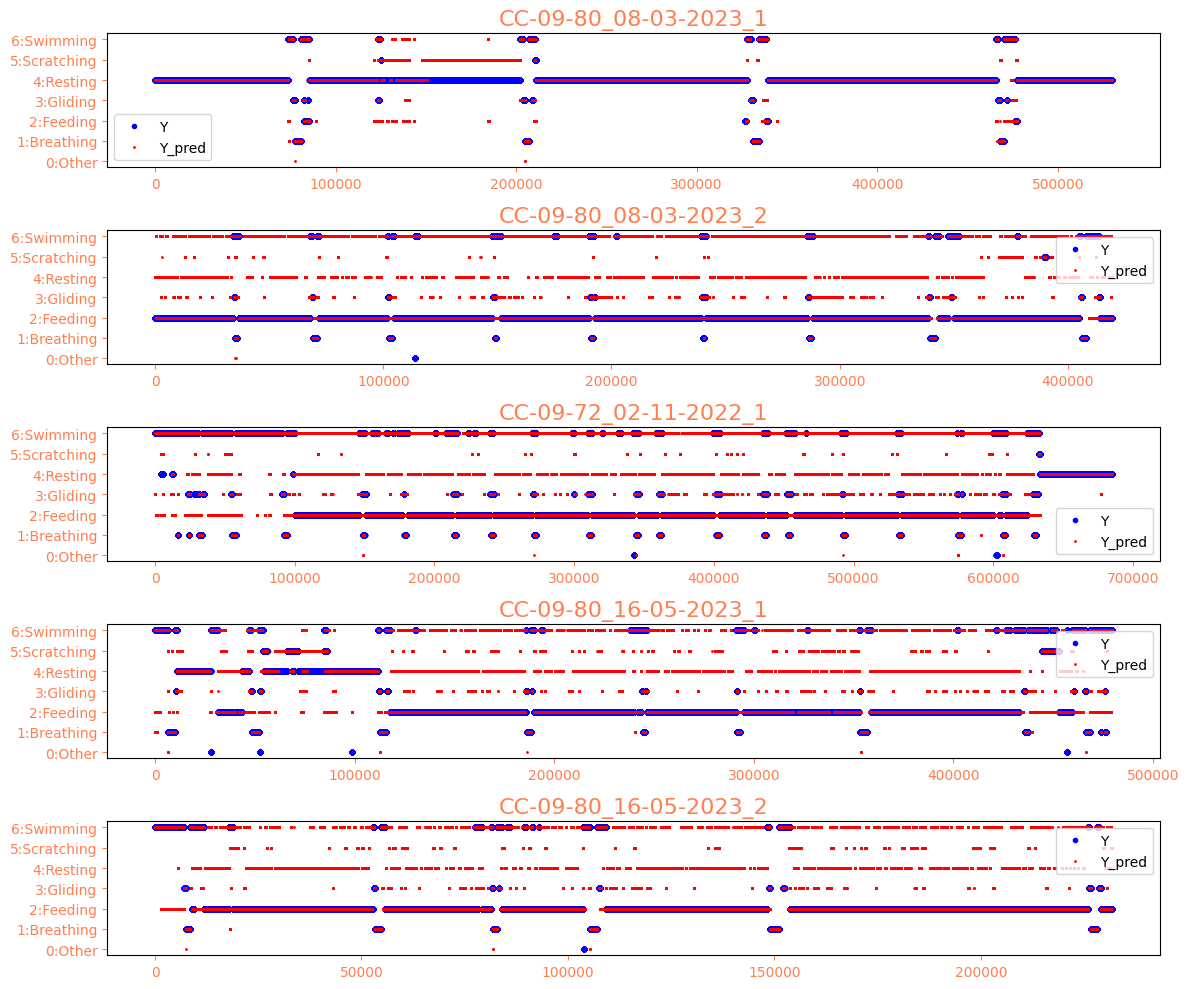

In [81]:
plot_compa(NAMES_TRAIN,"compa on train")

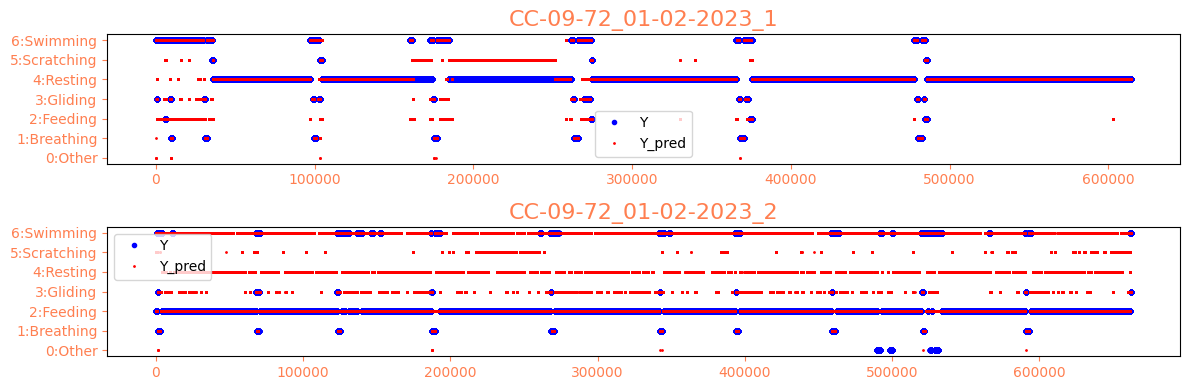

In [82]:
plot_compa(NAMES_VAL,"compa on val")

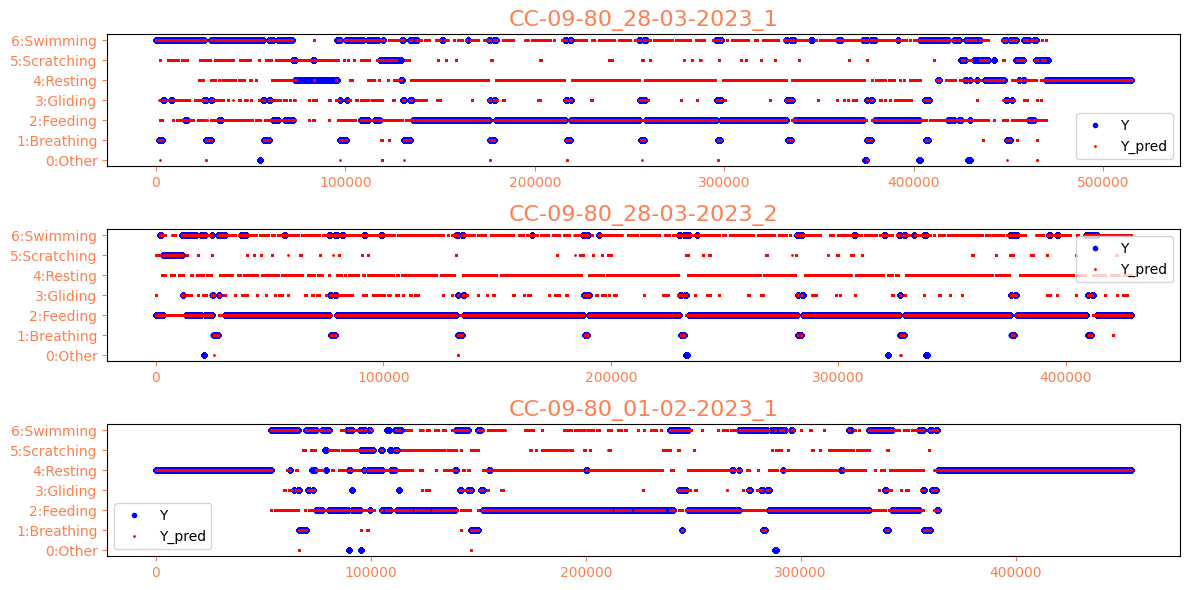

In [83]:
plot_compa(NAMES_TEST,"compa on test")

## Confusion Matrix


In [84]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize,
                          title,
                          cmap="jet",
                          precision=2,
                         ):


    y_true=y_true.astype(int)
    y_pred=y_pred.astype(int)

    np.set_printoptions(precision=precision)


    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    print("Confusion matrix, without normalization:")
    print(cm)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        print(cm)


    fig, ax = plt.subplots(figsize=(12,12))
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.'+str(precision)+'f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "coral")
    fig.tight_layout()
    fig.savefig(Folder_out+"/"+title)



Confusion matrix, without normalization:
[[     0      0   2366      0    325    135    391]
 [    23  46446    659    324      0   1089    780]
 [     0     26 551079   7379 197425  35727  55228]
 [     9    199   2507  20769   1852    333   1549]
 [     0      0   2776    535 205407  22350    498]
 [    13    433  19971    627   3047  16514   2199]
 [     0    375  55381   7906   8078   8416 116214]]
Normalized confusion matrix
[[0.00e+00 0.00e+00 7.35e-01 0.00e+00 1.01e-01 4.20e-02 1.22e-01]
 [4.66e-04 9.42e-01 1.34e-02 6.57e-03 0.00e+00 2.21e-02 1.58e-02]
 [0.00e+00 3.07e-05 6.51e-01 8.71e-03 2.33e-01 4.22e-02 6.52e-02]
 [3.31e-04 7.31e-03 9.21e-02 7.63e-01 6.80e-02 1.22e-02 5.69e-02]
 [0.00e+00 0.00e+00 1.20e-02 2.31e-03 8.87e-01 9.65e-02 2.15e-03]
 [3.04e-04 1.01e-02 4.67e-01 1.46e-02 7.12e-02 3.86e-01 5.14e-02]
 [0.00e+00 1.91e-03 2.82e-01 4.03e-02 4.11e-02 4.29e-02 5.92e-01]]


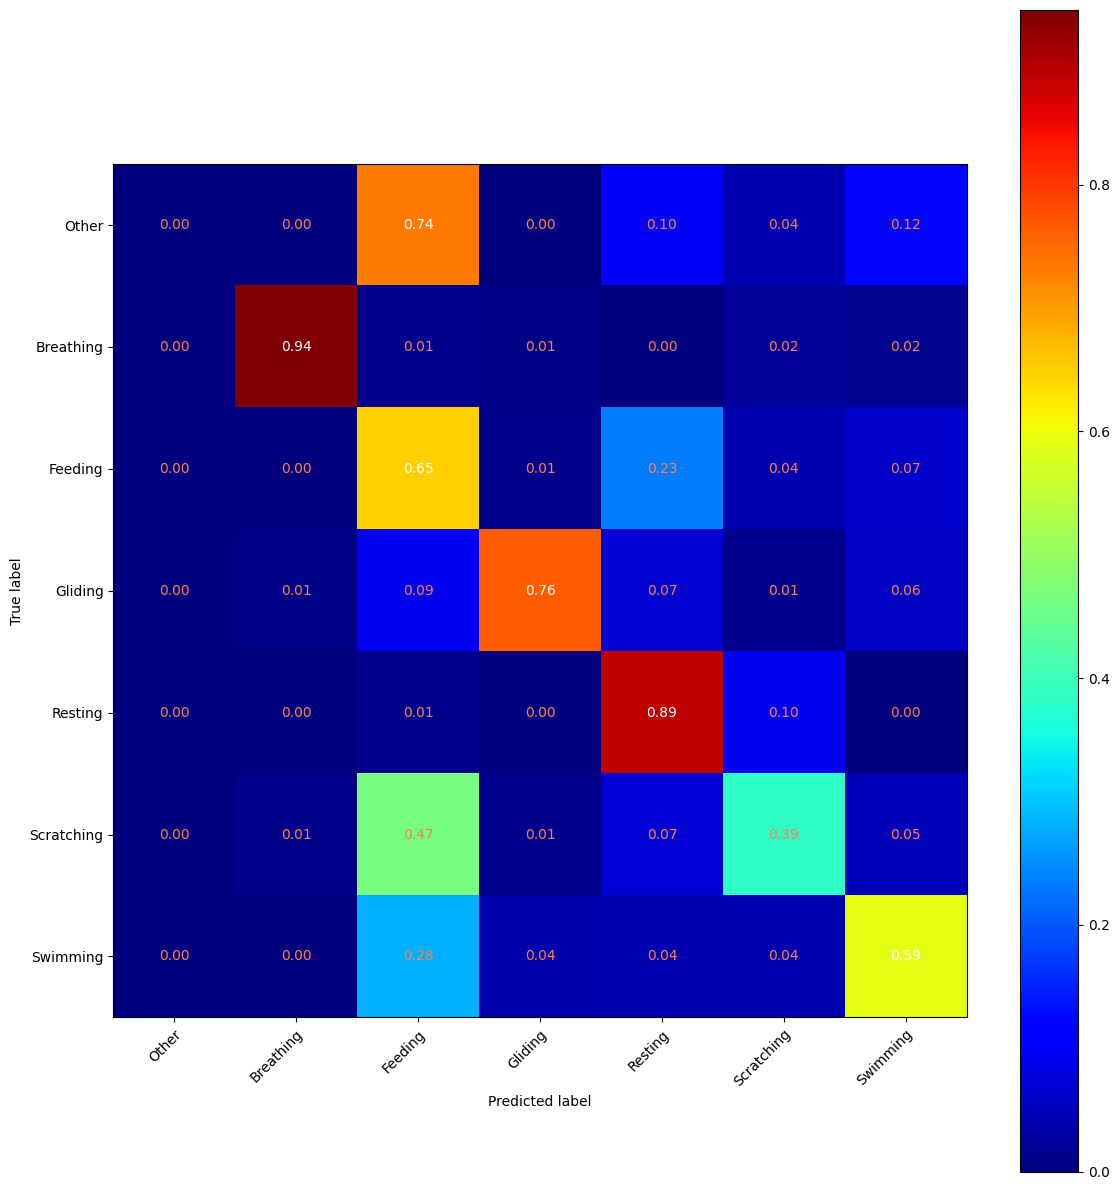

In [85]:
#calculate the confusion matrix only on the testing dataset
whole_true=[]
whole_pred=[]
for name in NAMES_TEST:
    whole_true.append(all_true[name])
    whole_pred.append(all_pred[name])

whole_true=np.concatenate(whole_true)
whole_pred=np.concatenate(whole_pred)
class_names=[CLASS.name for CLASS in CLASSES]

plot_confusion_matrix(whole_true,whole_pred, np.array(class_names),True,"whole validation")


In [86]:
#To calculate Precision,  Recall, Specificity and F1-score

cm = confusion_matrix(whole_true, whole_pred)

print(cm)
TP=np.diag(cm)
FP=np.sum(cm,axis=1)-TP
FN=np.sum(cm,axis=0)-TP
TN=np.ones(len(class_names))*np.sum(cm)-TP-FP-FN

Accuracy=(TP+TN)/(TP+TN+FP+FN)
Recall=TP/(TP+FN)
Precision =TP/(TP+FP)
Specificity =TN/(TN+FP)
F1_score=2*(Recall*Precision)/ (Recall+Precision)




[[     0      0   2366      0    325    135    391]
 [    23  46446    659    324      0   1089    780]
 [     0     26 551079   7379 197425  35727  55228]
 [     9    199   2507  20769   1852    333   1549]
 [     0      0   2776    535 205407  22350    498]
 [    13    433  19971    627   3047  16514   2199]
 [     0    375  55381   7906   8078   8416 116214]]


C:\Users\loren\AppData\Local\Temp\ipykernel_15212\2687499405.py:15: RuntimeWarning: invalid value encountered in divide
  F1_score=2*(Recall*Precision)/ (Recall+Precision)


In [87]:
df = pd.DataFrame({'Accuracy': Accuracy, 'Recall': Recall, 'Precision': Precision, 'Specificity': Specificity, 'F1_score': F1_score},
                      index = class_names)
df

,Accuracy,Recall,Precision,Specificity,F1_score
Other,0.997666,0.000000,0.000000,0.997698,NaN
Breathing,0.997203,0.978243,0.941708,0.997870,0.959628
Feeding,0.728456,0.868198,0.650729,0.612147,0.743896
Gliding,0.983383,0.553250,0.763061,0.995257,0.641434
Resting,0.830476,0.493608,0.887034,0.973340,0.634266
Scratching,0.932487,0.195284,0.385805,0.979974,0.259312
Swimming,0.899238,0.657100,0.591811,0.934325,0.622749


In [88]:
Global_accuracy=(np.sum(TP)+np.sum(TN))/(np.sum(TP)+np.sum(TN)+np.sum(FP)+np.sum(FN))
print("Global Accuracy :", Global_accuracy)

Global Accuracy : 0.909844073313759


In [89]:
F1_score=np.mean(df['F1_score'][~np.isnan(df['F1_score'])])
print("F1-score :", F1_score)

F1-score : 0.6435474158421729
